In [84]:
import sklearn

In [85]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [86]:
len(X), len(y)

(1000, 1000)

In [87]:
print(f"First 5 samples of x\n: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of x
: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [88]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


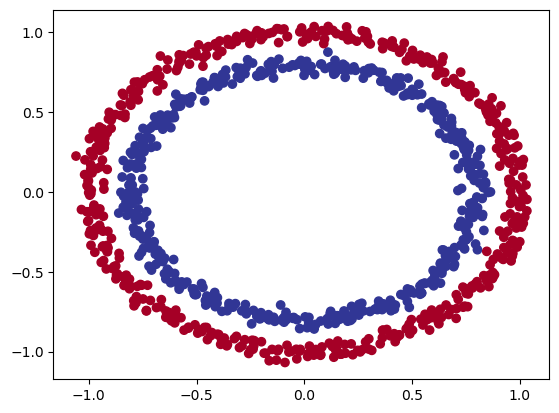

In [89]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [90]:
X.shape, y.shape

((1000, 2), (1000,))

In [91]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

#### Convert data into tensors

In [92]:
import torch
torch.__version__

'2.5.1+cu121'

In [93]:
type(X)

numpy.ndarray

In [94]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [95]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [96]:
# split data into training into test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [97]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [98]:
# 2. Building a model
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [120]:
class CircleModelV0(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        # create input layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a sigle feature (same shape as y)

        # USING nn.Sequential for building a neural network
        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )

    # 3. define a foward() method
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x))
        # return self.two_linear_layers(x)
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [121]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [122]:
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0

In [123]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2060], device='cuda:0'))])

In [124]:
# Make  predictions
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions : {len(untrained_preds)}, Shape : {untrained_preds.shape}")
print(f"Length of test samples : {len(X_test)}, Shape : {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels : \n{y_test[:10]}")

Length of predictions : 200, Shape : torch.Size([200, 1])
Length of test samples : 200, Shape : torch.Size([200, 2])

First 10 predictions:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 labels : 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


### Build a loss function and an optimizer

In [125]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [126]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2060], device='cuda:0'))])

In [127]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### Train our model

In [128]:
model_0.eval()

with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0')

In [129]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='cuda:0')

In [130]:
# Use the sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

In [131]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels =  torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

#### Building training loop and testing loop

In [132]:
torch.manual_seed(42) # <-- affects all device operations
torch.cuda.manual_seed(42) # <-- affects only cuda device

# set number of epochs
epochs = 1000

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits into pred probs -> pred labels

    # # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
    #                y_train)
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)


    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (update the parameter to reduce the gradient (Gradient descent))
    optimizer.step()

    # Tetsing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss : {test_loss:.5f}, Test acc : {test_acc:.2f}%")


Epoch : 0 | Loss: 0.69569, Acc: 50.00% | Test loss : 0.69721, Test acc : 50.00%
Epoch : 10 | Loss: 0.69403, Acc: 50.00% | Test loss : 0.69615, Test acc : 50.00%
Epoch : 20 | Loss: 0.69343, Acc: 46.00% | Test loss : 0.69585, Test acc : 48.50%
Epoch : 30 | Loss: 0.69321, Acc: 49.00% | Test loss : 0.69577, Test acc : 47.50%
Epoch : 40 | Loss: 0.69312, Acc: 49.50% | Test loss : 0.69573, Test acc : 46.50%
Epoch : 50 | Loss: 0.69308, Acc: 50.38% | Test loss : 0.69569, Test acc : 46.50%
Epoch : 60 | Loss: 0.69306, Acc: 50.50% | Test loss : 0.69564, Test acc : 46.50%
Epoch : 70 | Loss: 0.69305, Acc: 50.50% | Test loss : 0.69559, Test acc : 46.50%
Epoch : 80 | Loss: 0.69304, Acc: 50.75% | Test loss : 0.69553, Test acc : 46.50%
Epoch : 90 | Loss: 0.69303, Acc: 50.38% | Test loss : 0.69547, Test acc : 46.50%
Epoch : 100 | Loss: 0.69302, Acc: 50.50% | Test loss : 0.69542, Test acc : 46.50%
Epoch : 110 | Loss: 0.69302, Acc: 50.62% | Test loss : 0.69537, Test acc : 46.00%
Epoch : 120 | Loss: 0.69301

Import some code from github

Link : 
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [133]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper functions.py already exists")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")

    with open("../utils/helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary 

Download helper_functions.py


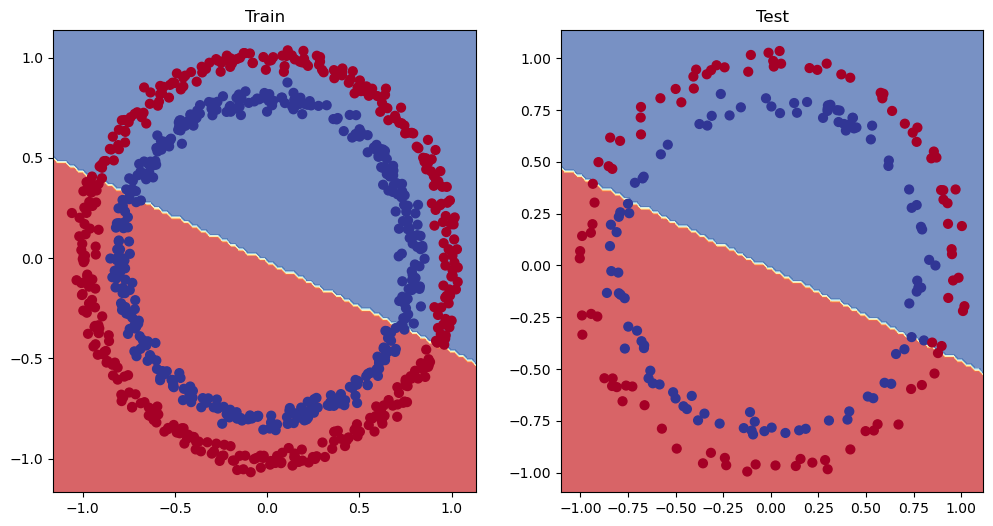

In [134]:
# Plot decision boundary of the model

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Improving model

* Add more layers
* Add more hidden unit

In [135]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5435,  0.5885],
                      [-0.1882,  0.6366],
                      [-0.1619,  0.1386],
                      [-0.3315,  0.4226],
                      [ 0.6150, -0.5235]])),
             ('layer_1.bias',
              tensor([0.6104, 0.1652, 0.5310, 0.0767, 0.3528])),
             ('layer_2.weight',
              tensor([[-0.0621,  0.3464,  0.1206, -0.1944,  0.1260]])),
             ('layer_2.bias', tensor([-0.1120]))])

In [144]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [146]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
                      [ 0.4082,  0.1265],
                      [ 0.3591, -0.4310]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.7000, -0.2732, -0.5424,  0.5802,  0.2037,  0.2929,  0.2236, -0.0123,
                       0.5534, -0.5024], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.0199, -0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874,
                       -0.1886, -0.1886],
                      [ 0.2844,  0.1054,  0.3043, -0.2610, -0.3137, -0.2474, -0.2127,  0.1281,
                        0.1132,  0.2628],
                      [-0.1633, -0.215

In [147]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [154]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = CircleModelV1().to(device)

epoch = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. perform backpropagation
    loss.backward()

    # 5. perform gradient descent
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss : {test_loss:.5f}, Test acc : {test_acc:.2f}%")


Epoch : 0 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 10 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 20 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 30 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 40 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 50 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 60 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 70 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 80 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 90 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 100 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 110 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 120 | Loss: 0.69396

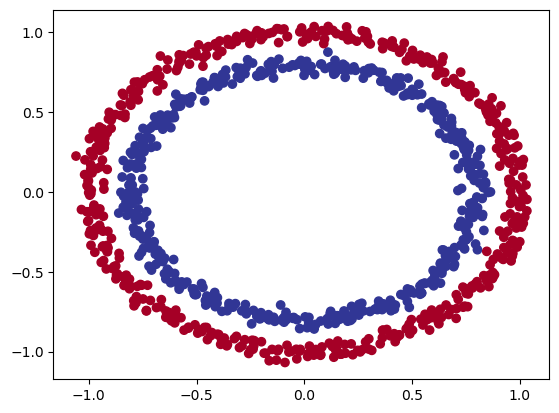

In [159]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [160]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5] 


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [ ]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [165]:
device

'cuda'

In [170]:
model_2 = CircleModelV2().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

model_2
epochs = 10000

for epoch in range(epochs):
    model_2.train()

    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # set zero gradient
    optimizer.zero_grad()

    # perform backpropagation
    loss.backward()

    # perform gradient descent
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc_loss = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.2f}, Acc : {acc:.2f}% | Test Loss: {test_loss:.2f} | Test acc: {test_acc_loss}")

Epoch : 0 | Loss : 0.69, Acc : 50.00% | Test Loss: 0.69 | Test acc: 50.0
Epoch : 100 | Loss : 0.69, Acc : 52.88% | Test Loss: 0.69 | Test acc: 52.5
Epoch : 200 | Loss : 0.69, Acc : 53.37% | Test Loss: 0.69 | Test acc: 55.00000000000001
Epoch : 300 | Loss : 0.69, Acc : 53.00% | Test Loss: 0.69 | Test acc: 56.00000000000001
Epoch : 400 | Loss : 0.69, Acc : 52.75% | Test Loss: 0.68 | Test acc: 56.49999999999999
Epoch : 500 | Loss : 0.68, Acc : 52.75% | Test Loss: 0.68 | Test acc: 56.49999999999999
Epoch : 600 | Loss : 0.68, Acc : 54.50% | Test Loss: 0.67 | Test acc: 56.00000000000001
Epoch : 700 | Loss : 0.67, Acc : 58.38% | Test Loss: 0.66 | Test acc: 59.0
Epoch : 800 | Loss : 0.65, Acc : 64.00% | Test Loss: 0.65 | Test acc: 67.5
Epoch : 900 | Loss : 0.62, Acc : 74.00% | Test Loss: 0.62 | Test acc: 79.0
Epoch : 1000 | Loss : 0.57, Acc : 87.75% | Test Loss: 0.57 | Test acc: 86.5
Epoch : 1100 | Loss : 0.48, Acc : 93.50% | Test Loss: 0.50 | Test acc: 90.5
Epoch : 1200 | Loss : 0.37, Acc : 9

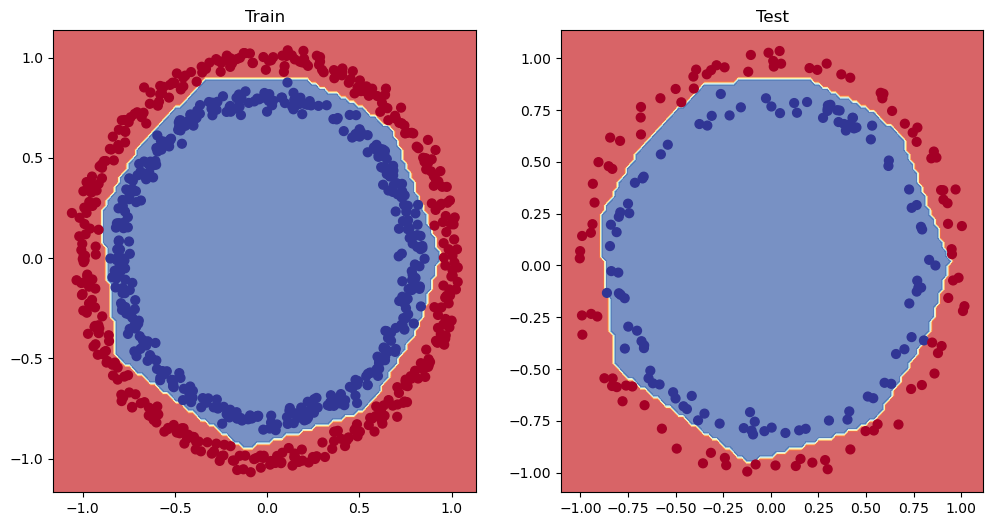

In [171]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)